In [13]:
import sys
import os
import numpy as np
sys.path.insert(0, '..')

In [14]:
from gait_analysis.Datasets import TumGAID_Dataset
from gait_analysis import settings as S

## TUMGAID example
tumgaid_args = {
    'load_pose': True,
    'load_pose_options': {
        'D': 2,
        'body_keypoints_include_list': ['LAnkle',
                                        'RAnkle',
                                        'LKnee',
                                        'RKnee',
                                        'RHip',
                                        'LHip']
    },
    'load_flow': False,
    'load_flow_options': {
        'method': 'dense',
        'load_patches': True,
        'load_patch_options': {
            'patch_size': 5
        }
    },
    'load_scene': False,
    'load_scene_options': {
        'grayscale': False,
        'load_tracked': False
    },
    'include_scenes': ['b01', 'b02', 'n01', 'n02', 's01', 's02'],

}
tg_dset = TumGAID_Dataset(S.tumgaid_root,
                          S.tumgaid_preprocessing_root,
                          S.tumgaid_annotations_root,
                          tumgaid_args)

In [15]:
tg_dset.p_nums

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 301, 302, 303, 304, 305]

# Split dataset into Train and Validation

In [18]:
import sklearn
from sklearn.model_selection import train_test_split

split_index = 10
p_nums_train = tg_dset.p_nums[:split_index]
p_nums_test = tg_dset.p_nums[split_index:]
def create_idx_list(p_nums_list):
    idx_list = []
    for i, dset_item in enumerate(tg_dset.dataset_items):
        p_num, _ = dset_item
        if p_num in p_nums_list:
            idx_list.append(i)
    return idx_list
idx_train = create_idx_list(p_nums_train)
idx_test = create_idx_list(p_nums_test)

# Training Loop

In [19]:
def annotations_to_targets(annotations):
    '''
    IN_THE_AIR == TRUE
    '''
    a = annotations.left_foot.values == 'IN_THE_AIR'    
    return a * 1

def flatten_features(single_frame_feature):
    return np.ravel(features['pose_keypoints'][0])

temporal_extent = 2 #will concatenate +- N frame features together into a single feature vector

In [20]:
def yield_kXY(temporal_extent, flat_features, targets):
    '''
    yields an X and a Y given a list of flat_features and a list of targets.
    The temporal_extent will concatenate neighboring frames into a single features vector.
    The target will be the center frame of the concatenate extent
    
    yields index k of the sequence of flat_features
    concatenated features X
    target Y
    '''
    for k in range(temporal_extent, len(flat_features) - temporal_extent):
        x_start, x_end = np.array([-temporal_extent, temporal_extent]) + k
        X = np.hstack(flat_features[x_start:x_end + 1])
        X = np.reshape(X, (1, -1))
        Y = targets[k]
        yield k, X, Y

# Initialize Model

In [36]:
#from gait_analysis.Models.OtherModels import SVMModel
from gait_analysis.Models.BaseModels import AbstractGaitModel
from gait_analysis.Models.OtherModels import SVMModel
from sklearn import svm

svm_obj = svm.SVC()
model = SVMModel(svm_obj)

In [37]:
for idx in idx_train:
    features, annotations = tg_dset[idx]
    targets = annotations_to_targets(annotations)
    flat_features = list(map(flatten_features, features['pose_keypoints']))
    for _, X, Y in yield_kXY(temporal_extent, flat_features, targets):
        model.train(X, Y)
model.finish_training() # actually fit svm

In [38]:
print(model.target_list.shape)
print(model.feature_list.shape)

(3677,)
(3677, 60)


In [41]:
import pandas as pd
result_dict = {}
for idx in idx_test:
    features, annotations = tg_dset[idx]
    targets = annotations_to_targets(annotations)
    flat_features = list(map(flatten_features, features['pose_keypoints']))
    
    sequence_output = {
        'frame_id' : [],
        'target' : [],
        'prediction' : []
    }
    for k, X, Y in yield_kXY(temporal_extent, flat_features, targets):
        prediction = model.svm_obj.predict(X)                
        sequence_output['frame_id'].append(k)
        sequence_output['target'].append(Y)
        sequence_output['prediction'].append(prediction)
        
    result_dict[idx] = sequence_output

In [42]:
df = pd.DataFrame(result_dict)

In [43]:
idx_test

[60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89]

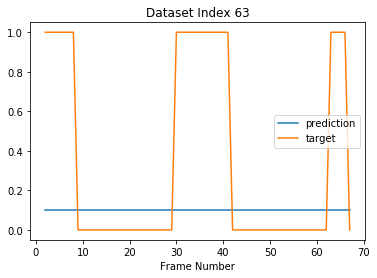

In [44]:
from matplotlib import pyplot as plt

def plot_single_sequence(sequence_id, data_frame):
    a = data_frame[sequence_id]
    fig, ax = plt.subplots()
    x = a['frame_id']
    ax.plot(x, a['prediction'], label='prediction')
    ax.plot(x, a['target'], label='target')
    plt.legend()
    plt.xlabel('Frame Number')
    plt.title('Dataset Index {}'.format(sequence_id))
    return fig, ax

%matplotlib inline
fig, ax = plot_single_sequence(63, df)